In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

from skimage.transform import resize
from skimage.io import imread


from tqdm import tqdm
import pickle

# 병렬연산
from concurrent.futures import ThreadPoolExecutor

import os
import warnings
warnings.filterwarnings(action='ignore')

import cv2
from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split

In [3]:
### 사용자 정의 함수
%cd /content/drive/MyDrive/project3

# Add the paths to the modules to the Python path
import sys
sys.path.append(os.path.abspath('./code/image_function'))

from image_load import resize_image, load_image, load_and_resize_images
from vram_reset import reset_vram

/content/drive/.shortcut-targets-by-id/1gdU-KuXDUU7v2o8X7TdV0JgGiz603mCc/project3


In [4]:
food_middle_list = [] # 중분류
food_path_list = [] # 중분류 경로
datadir = '/content/drive/MyDrive/project3/data/traindata/kfood/'
for food_middle in sorted(os.listdir(datadir)):
    middle_path = os.path.join(datadir,food_middle)
    food_middle_list.append(food_middle)

    for food in os.listdir(middle_path):
      path = os.path.join(middle_path, food)
      food_path_list.append(path)

print(len(food_middle_list))
print(food_middle_list)
print(food_path_list)

13
['구이', '국', '기타', '김치', '나물', '떡', '만두', '면', '무침', '밥', '볶음', '쌈', '음청류']
['/content/drive/MyDrive/project3/data/traindata/kfood/구이/갈비구이', '/content/drive/MyDrive/project3/data/traindata/kfood/구이/갈치구이', '/content/drive/MyDrive/project3/data/traindata/kfood/구이/고등어구이', '/content/drive/MyDrive/project3/data/traindata/kfood/구이/곱창구이', '/content/drive/MyDrive/project3/data/traindata/kfood/구이/닭갈비', '/content/drive/MyDrive/project3/data/traindata/kfood/구이/장어구이', '/content/drive/MyDrive/project3/data/traindata/kfood/구이/조개구이', '/content/drive/MyDrive/project3/data/traindata/kfood/구이/떡갈비', '/content/drive/MyDrive/project3/data/traindata/kfood/구이/불고기', '/content/drive/MyDrive/project3/data/traindata/kfood/구이/삼겹살', '/content/drive/MyDrive/project3/data/traindata/kfood/구이/더덕구이', '/content/drive/MyDrive/project3/data/traindata/kfood/구이/조기구이', '/content/drive/MyDrive/project3/data

In [8]:
new_img_size = (224,224)
pic_count = 100

image_list, target_list, except_list = load_and_resize_images(food_path_list, food_middle_list, img_size = new_img_size)

Processing images: 100%|██████████| 13/13 [01:21<00:00,  6.24s/it]


In [10]:
np.unique(target_list)

array(['구이', '국', '기타', '김치', '나물', '떡', '만두', '면',
       '무침', '밥', '볶음', '쌈', '음청류'], dtype='<U8')

In [11]:
categories_label = {category:i for i, category in enumerate(np.unique(target_list))} # 카테고리랑 숫자로 바꾼 값 dict형태로 만들기
target_num = np.array([categories_label[category] for category in target_list], dtype=np.int8)

In [12]:
categories_label

{'구이': 0,
 '국': 1,
 '기타': 2,
 '김치': 3,
 '나물': 4,
 '떡': 5,
 '만두': 6,
 '면': 7,
 '무침': 8,
 '밥': 9,
 '볶음': 10,
 '쌈': 11,
 '음청류': 12}

In [26]:
len(image_list)

1298

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_list, target_num, test_size=0.2, random_state=42)

In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1038, 224, 224, 3), (260, 224, 224, 3), (1038,), (260,))

In [16]:
# 0 ~ 1 값으로 정규화
X_train = X_train / 255.0
X_test = X_test / 255.0

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(13, activation=tf.nn.softmax)
])

In [23]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [24]:
history = model.fit(X_train, y_train, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
7/7 [==============================] - 11s 690ms/step - loss: 7.7638 - accuracy: 0.0663 - val_loss: 3.0728 - val_accuracy: 0.1010
Epoch 2/20
7/7 [==============================] - 1s 139ms/step - loss: 2.7366 - accuracy: 0.1036 - val_loss: 2.5901 - val_accuracy: 0.0673
Epoch 3/20
7/7 [==============================] - 1s 136ms/step - loss: 2.5244 - accuracy: 0.0807 - val_loss: 2.5563 - val_accuracy: 0.0817
Epoch 4/20
7/7 [==============================] - 1s 142ms/step - loss: 2.3759 - accuracy: 0.2651 - val_loss: 2.5865 - val_accuracy: 0.1298
Epoch 5/20
7/7 [==============================] - 1s 141ms/step - loss: 1.9951 - accuracy: 0.4831 - val_loss: 2.5027 - val_accuracy: 0.1587
Epoch 6/20
7/7 [==============================] - 1s 141ms/step - loss: 1.4135 - accuracy: 0.6759 - val_loss: 2.8331 - val_accuracy: 0.1923
Epoch 7/20
7/7 [==============================] - 1s 141ms/step - loss: 0.9120 - accuracy: 0.7759 - val_loss: 2.7342 - val_accuracy: 0.1875
Epoch 8/20
7/7 [===

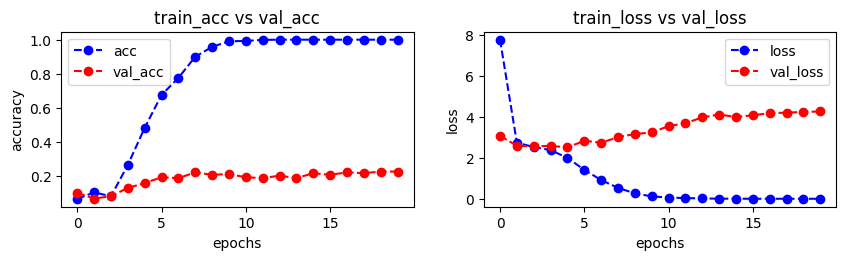

In [27]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

plot_accuracy_loss(history)

In [28]:
predictions = model.predict(X_test)

# Convert the logits to probabilities
probabilities = tf.nn.softmax(predictions)

# Get the class with the highest probability
predicted_classes = np.argmax(probabilities, axis=1)

# Compare the predicted classes with the actual classes
comparison = list(zip(predicted_classes, y_test))

# Display the first 10 predictions and actual values
for i in range(10):
    print(f'Predicted: {predicted_classes[i]}, Actual: {y_test[i]}')

9/9 [==============================] - 1s 29ms/step
Predicted: 8, Actual: 9
Predicted: 8, Actual: 8
Predicted: 3, Actual: 11
Predicted: 2, Actual: 6
Predicted: 7, Actual: 0
Predicted: 0, Actual: 7
Predicted: 5, Actual: 8
Predicted: 11, Actual: 11
Predicted: 4, Actual: 1
Predicted: 0, Actual: 7
